# Modélisation de la consommation et de la production d'un foyer équipé d'un photovoltaique, d'une éolienne et d'une batterie

Ce notebook permet de reproduire les expériences du papier :

SMART EASE, UNE METHODE ECONOME POUR OPTIMISER LE STOCKAGE ELECTRIQUE A L’ECHELLE DU CONSOMMATEUR
Pierre-Louis Guhur et Charles Lorenzo


 
## Estimation de la consommation
On estime que le foyer a une consommation électrique annuelle de 20000 kWh[1]. L'historique de météo est donné par Meteblue [2]. Les données de consommation proviennent du gouvernement suisse [3]. Les heures creuses/pleines sont prises pour Cachan.

[1] http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php "Consommation moyenne d'une maison"

[2] https://www.meteoblue.com/ "Historique météorologique"

[3] https://www.swissgrid.ch/ "Dataset de consommation"

## Prix de l'électricité
http://www.kelwatt.fr/guide/prix-par-mois#base

http://www.jechange.fr/energie/electricite/guides/prix-electricite-kwh-2435
- Abonnement annuel : 117,50 €
- Evolution des prix sur 2013 en suivant l'historique de :
http://www.kelwatt.fr/prix/tarif-bleu-edf#trouver-moins-cher-tarif-bleu
- prix du kWh: (heures pleines, heures creuses) = 0.129, 0.105


Rachat du photovoltaïque :
- Intégration au bâti :
    0-9 kWc = 24,29 cts€/kWh (24,64 cts€/kWh le trimestre précédent)
- Intégration simplifiée au bâti :
    0-36 kW = 12,72 cts€/kWh (13,27 cts€/kWh le trimestre précédent)
    36-100 kW = 12,13 cts€/kWh (12,62 cts€/kWh le trimestre précédent)
- Sans intégration, ou hors critères ci-dessus, ou au sol:
    5,65 c€/kWh (5,96 cts€/kwh le trimestre précédent)

Rachat de l'éolien :
- http://www.developpement-durable.gouv.fr/Les-tarifs-d-achat-de-l,12195.html
- prix: 8.2cEUR/kWh

## Initialisation 1/2

In [1]:
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss

import collections
import pickle
import random
import locale, time
locale.setlocale(locale.LC_TIME, "fr_FR".encode('ascii'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
# from __future__ import unicode_literals
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = True
rc('font',**{'family':'serif','serif':['Calibri']})

%matplotlib inline



# données météo 
bale=pd.read_csv('dataset/history_export_2017-02-04T14-20-45.csv', sep=";", skiprows=11)
bale["date"]=pd.to_datetime({
        'year': bale["Year"],
        'month': bale["Month"],
        'day': bale["Day"],
        'hour': bale["Hour"],
                    })
bale = bale.set_index(['date'])
bale["radiation"] = bale["Shortwave Radiation - backwards"]/1000



# données de consommation
df_14=pd.read_csv('dataset/conso_bale_2014.csv', sep=",") # attention les données de 2014 sont moins fiables : toute la Suisse
df_14['kWh']/=df_14['kWh'].sum()
df_15=pd.read_csv('dataset/conso_bale_2015.csv', sep=",")
df_15['kWh']/=df_15['kWh'].sum()
df_16=pd.read_csv('dataset/conso_bale_2016.csv', sep=",")
df_16['kWh']/=df_16['kWh'].sum()
df = pd.concat([df_14, df_15, df_16])
df["date"]=pd.to_datetime(df["date"])
df = df.set_index(['date'])
consoPerso = 20000 # consommation annuelle kWh d'un foyer
# 20000 pour un foyer : http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php
df['kWh']*=consoPerso
df['kWh'].loc[df.index.year == 2016]*=float(len(df[df.index.year == 2016]))/len(df[df.index.year == 2015])
df = df.resample('60T').sum()
df = df[~df.index.duplicated()] # resoud les passages aux heures d'hiver et d'ete
df = df.fillna(method='ffill')
bale["consommation"] =  df["kWh"]

# Index (intersection of df and bale)
bale = bale.reindex(bale.index.intersection(df.index))
hour = bale.index.hour
month = bale.index.month
HC = ((hour >= 2) & (hour < 7)) | ((hour >= 14) & (hour < 17))
HP =  ((hour >= 7) & (hour < 14)) | (hour >= 17) | (hour < 2)


prix_achat = np.array([0.15600,0.12700 ])
bale["inflation"] = pd.Series(1, df.index)
abonnement = 117.5
abonnement_heure = abonnement/365.25/24
prix_hc = prix_achat[1]* bale["inflation"] +abonnement_heure
prix_hp = prix_achat[0]* bale["inflation"] +abonnement_heure
prix = prix_hp
prix.loc[(hour >= 2) & (hour < 7)] = prix_hc[(hour >= 2) & (hour < 7)]
prix.loc[(hour >= 14) & (hour < 17)] = prix_hc[(hour >= 14) & (hour < 17)]
bale["depense"] = bale["consommation"].copy()
bale["depense"].loc[HC] *= prix_hc
bale["depense"].loc[HP] *= prix_hp
prix_pv = 0.1272 - abonnement_heure
prix_eolien = 0.082 - abonnement_heure 



def prediction(X_train, y_train, X_test, y_test = 0):
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}

    conf = {'estimator': GradientBoostingRegressor,
         'tuned_params': {'loss': 'ls'},
         'changing_param': 'n_estimators',
         'changing_param_value': 3000,
         'complexity_label': 'n_trees',
         'complexity_computer': lambda x: x.n_estimators,
         'data': data,
         'postfit_hook': lambda x: x,
         'prediction_performance_computer': mean_squared_error,
         'prediction_performance_label': 'MSE'
        }

    conf['tuned_params'][conf['changing_param']] = conf['changing_param_value']
    estimator = conf['estimator'](**conf['tuned_params'])
    estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
    conf['postfit_hook'](estimator)
    start_time = time.time()
    y_pred = estimator.predict(conf['data']['X_test'])
    print "Temps d'exécution de la prédiction : %f " % (time.time() - start_time)
    pred_score = 0
    if y_test != 0:
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
    return [y_pred, pred_score]

def Depense(manque, rachat=prix_eolien):
    depense = pd.Series(0, index=manque.index)
    depense[manque.values < 0] += manque[manque.values < 0]*rachat
    depense[(manque.values > 0)] += manque[(manque.values > 0)]*prix
    return depense.cumsum()

# test:
# manque = pd.Series(np.random.rand(len(bale.index)), index=bale.index)
# Depense(manque,(bale.index.year == 2016)).plot()


###########
# Prédiction de la consommation
# On prédit 2016 selon 2015 et 2015 selon 2014 (attention données peu fiables sur 2014)

a2014 = (bale.index.year == 2014) 
a2015 = (bale.index.year == 2015) 
a2016 = (bale.index.year == 2016)

view = bale[['Temperature', "Shortwave Radiation - backwards", 'Wind Gust', 'Wind speed', \
             'Relative humidity', 'Mean Sea Level Pressure', 'Total Precipitation', \
             'Snowfall amount', 'Total cloud cover', 'High cloud cover', \
            'Low cloud cover', 'Shortwave Radiation - backwards', 'Wind speed', 'Wind direction', 'Hour']]

bale["prediction"] = pd.Series(np.nan, index=bale.index)
[bale["prediction"].loc[a2015], _] = prediction(view[a2014], bale["consommation"][a2014], view[a2015])
[bale["prediction"].loc[a2016], _] = prediction(view[a2015], bale["consommation"][a2015], view[a2016])


/Library/Python/2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Temps d'exécution de la prédiction : 0.307624 
Temps d'exécution de la prédiction : 0.306779 


# Initialisation 2/2
## Production d'électricité photovoltaïque et éolienne
Thèse O. Gergaud, modèle polynomial
$P_{G,max} = P_1\left[ 1 + P_2 (T - T_{ref}) \right] (P_3 + E_s)$
avec :
- $P_1 = 0.99$ (ou 0.099 pour un panneau)
- $P_2 = -4.7e^{-3} K^{-1}$ dérive en température
- $P_3 = 45$
- $T_{ref} = 24°C$
- $E_s$ ensoleillement dans le plan de panneaux (W/m^2)

Eolienne considérée :
- http://www.fw4sea.com/produits-fr/fiches-techniques/80-fiches-techniques-fr/88-f180-50

/Users/pierre-louis/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


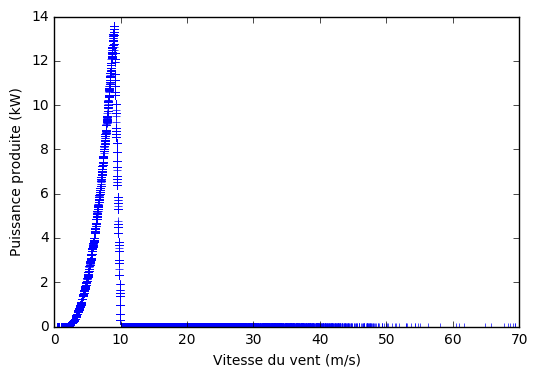

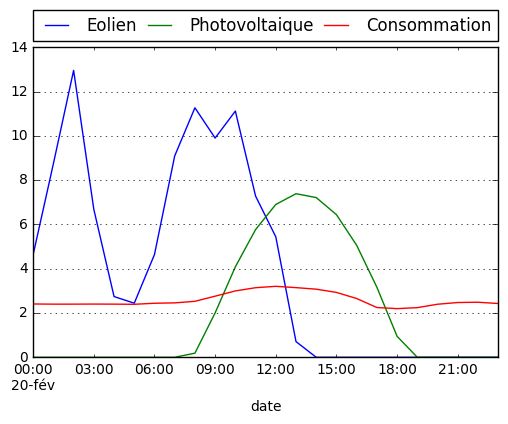

In [2]:
P1 =  14 #rendement de 30m2 de panneau solaire
P2 = -4.7e-3 #deviation en temperatrue
P3 = 0 #gain supplémentaire
Tref = 24
NOCT = 43
bale["prod-pv"] = P1*( 1 + P2*(bale["Shortwave Radiation - backwards"]*1e-3* \
                        (NOCT-20)/800))*(P3+bale["Shortwave Radiation - backwards"]*1e-3)
period = (bale.index.month == 2) & (bale.index.day == 20) & (bale.index.year == 2015)

# F180-50
# puissance = np.ones(20)* 50.0
# puissance[:10]= [0,0,1,2.16,5.12,9.5,15.55, 23.52, 33.65, 45.0]
# Modele F180-36
puissance = np.ones(20)*0.0
puissance[:10]= [0,0,0,0.68,2.5, 5.45, 9.85, 15.9, 23.85, 33.9]
puissance = puissance*0.4
bale['prod-eol'] = np.interp( bale['Wind speed'].values, np.arange(20.0), puissance)

plt.figure()
ax = plt.plot(bale['Wind speed'], bale['prod-eol'].values, '+')
plt.xlabel("Vitesse du vent (m/s)")
plt.ylabel("Puissance produite (kW)")
plt.show()

ax = bale[period].plot(y='prod-eol', label="Eolien")
bale[period].plot(y="prod-pv", label="Photovoltaique", ax=ax)
bale[period].plot(y="consommation", label="Consommation", ax=ax)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
ax.yaxis.grid()
plt.show()

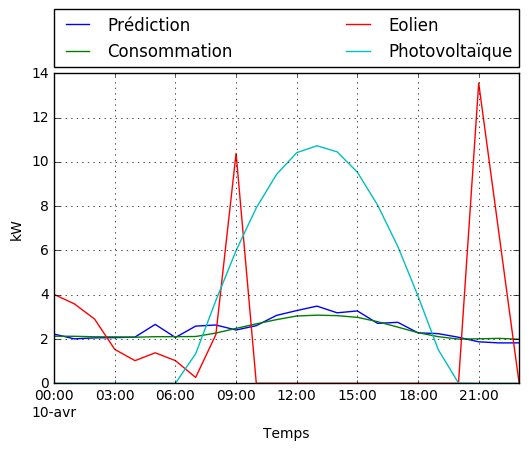

In [3]:
plt.figure()
period = a2016 & (month == 4) & (bale.index.day == 10)
bale["prediction"][period].plot(label="Prédiction")
bale["consommation"][period].plot(label="Consommation")
bale["prod-eol"][period].plot(label="Eolien")
bale["prod-pv"][period].plot(label="Photovoltaïque")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax = plt.gca()
ax.grid(True, which='both')
plt.xlabel("Temps")
plt.ylabel("kW")
plt.show() 

## Loi de commande 
    - Vente: on vend tout, puis on achète selon nos besoins
    - Consommation: on consomme ce qu'on produit, puis on vend les surplus
    - BatterieNormale: on stocke les surplus
    - BatterieAchat: à la fin d'une période d'heures creuses, on achète pour remplir la batterie jusqu'à un certain stade
    - BatterieAchatOpt: à la fin d'une période d'heures creuses, on achète pour remplir la batterie afin ne pas manquer d'électricité lors d'une période d'heures pleines

In [30]:
def LoiVente(consommation, production, mask, rachat=prix_eolien):
    depense = -production[mask]*rachat
    depense += consommation[mask]*prix[mask]
    return depense.cumsum()

def LoiConso(consommation, production, mask, rachat=prix_eolien):
    besoin = (consommation - production)
    return Depense(besoin[mask], rachat)

def LoiNormale(prod, cap_batterie, mask, conso = bale["consommation"],  rendement=0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[mask].index) 
    besoin = (conso-bale[prod])[mask] if prod != "no-prod" else conso[mask]
    stockage = pd.Series(0, index=bale[mask].index) 
    manque = pd.Series(0, index=bale[mask].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    stockagePre = 0.0
    for p in bale[mask].index:
        m=  bale[mask].index == p
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and -besoin[m].values[0] > (cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = (cap_batterie - stockagePre) -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and -besoin[m].values[0] < (cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        stockagePre = stockage[m].values[0]

    return [manque, stockage]

def LoiAchat(prod, cap_batterie, mask, coeff = 1.0, rendement = 0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[mask].index) 
    stockage = pd.Series(0, index=bale[mask].index) 
    manque = pd.Series(0, index=bale[mask].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    besoin = (bale["consommation"]-bale[prod])[mask] if prod != "no-prod" else bale["consommation"][mask]
    stockagePre = 0.0
    for p in bale[mask].index:
        m=  bale[mask].index == p
        transfert = 0 # > 0 si maison -> batterie, <= 0 sinon
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] > cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = cap_batterie - stockagePre -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] < cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        h = p.hour
        if (h == 16 or h == 6) and (stockage[m].values[0] < cap_batterie*coeff):
            manque[m] += cap_batterie*coeff - stockage[m].values[0] 
            stockage[m] = cap_batterie*coeff 
        stockagePre = stockage[m].values[0]

    return [manque, stockage]

def Anticipation(prod, cap_batterie, mask, conso = bale["consommation"], rendement = 0.9):
# calcul ce dont il faut acheter pour subvenir aux besoins futurs de la HP
    [manque, stockage] = LoiNormale(prod, cap_batterie, mask, conso=conso, rendement= rendement)
    return manque[manque > 0 ].sum()
    
def LoiOptimal(prod,cap_batterie, mask, rendement = 0.9, conso=bale['consommation']):
    batteriePleine = pd.Series(cap_batterie, index=bale[mask].index) 
    stockage = pd.Series(0, index=bale[mask].index) 
    decision_times = pd.Series(0,index=bale[mask].index)
    manque = pd.Series(0, index=bale[mask].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    besoin = (conso-bale[prod])[mask] if prod != "no-prod" else conso[mask]
    stockagePre = 0.0
    for p in bale[mask].index:
        start_time = time.time()
        m=  bale[mask].index == p
        transfert = 0 # > 0 si maison -> batterie, <= 0 sinon
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] > cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = cap_batterie - stockagePre -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] < cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        h = p.hour
        if (h == 16):
            periodHP = mask & (bale.index >= (p + pd.DateOffset(hours=1)))
            periodHP &= bale.index <= (p + pd.DateOffset(hours=10))
            besoinHP = Anticipation(prod, cap_batterie, periodHP, conso=conso)
            if (besoinHP > stockage[m].values[0] ):
                manque[m] += min(besoinHP, cap_batterie) - stockage[m].values[0] 
                stockage[m] = min(besoinHP, cap_batterie)
        if (h == 6):
            periodHP = mask & (bale.index >= (p + pd.DateOffset(hours=1)))
            periodHP &= bale.index <= (p + pd.DateOffset(hours=8))
            besoinHP = Anticipation(prod, cap_batterie, periodHP, conso=conso)
            if (besoinHP > stockage[m].values[0] ):
                manque[m] += min(besoinHP, cap_batterie) - stockage[m].values[0] 
                stockage[m] = min(besoinHP, cap_batterie)

        stockagePre = stockage[m].values[0]
        decision_times[m] = (time.time() - start_time)
    
    print "Temps d'exécution: "
    print decision_times.describe()
    return [manque, stockage]

## Besoin, manque et stockage sur une journée

0.350057029299


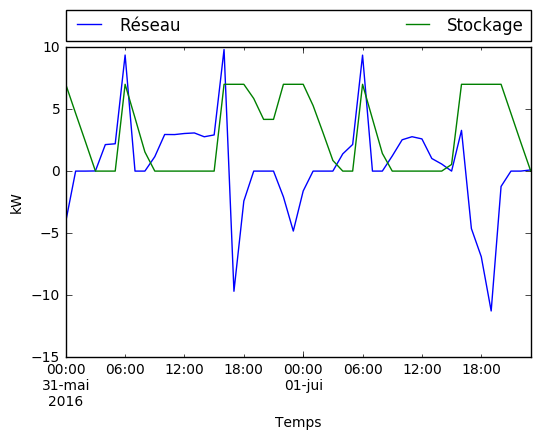

In [5]:
plt.figure()
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False
rc('font',**{'family':'serif','serif':['Calibri']})
period = (bale.index.year == 2016) &  ((bale.index.month == 5) & (bale.index.day == 31) | (bale.index.month == 6) & (bale.index.day == 1))
cap_batterie = 7
besoin = (bale['consommation'] - bale['prod-eol'])[period]
[manque, stockage] = LoiAchat('prod-eol',  cap_batterie, period)
# besoin.plot(label="Besoin")
manque.plot(label="Réseau")
stockage.plot(label="Stockage")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
#ax.grid(True, which='both')
plt.xlabel("Temps")
plt.ylabel("kW")
print besoin.mean()

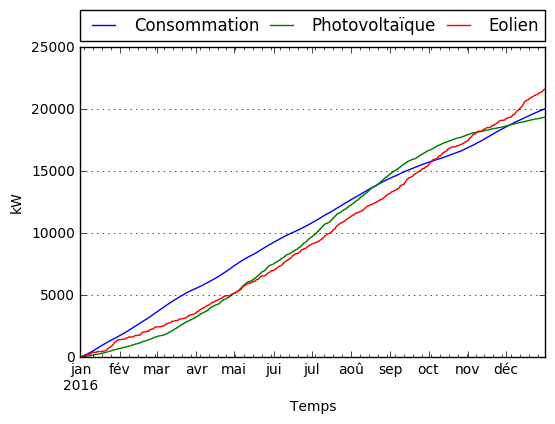

In [6]:
period = bale.index.year == 2016
plt.figure()
bale['consommation'][period].cumsum().plot(label="Consommation")
bale['prod-pv'][period].cumsum().plot(label="Photovoltaïque")
bale['prod-eol'][period].cumsum().plot(label="Eolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)

plt.xlabel("Temps")
plt.ylabel("kW")
ax = plt.gca()
ax.yaxis.grid()
plt.show()

## Facture avec le photovoltaïque

In [8]:
# period = (bale.index.month == 1) & (bale.index.day == 1)
period = (bale.index.year == 2016)
cap_batterie = 14
besoin = (bale['consommation'] - bale['prod-pv'])[period]
pv = {}
rendement = 0.9

# 1. en vendant systematiquement notre production de photovoltaique
pv['Basique'] = LoiVente(bale['consommation'], bale['prod-pv'], period, prix_pv)

# 2. On consomme notre production de photovoltaique et on vend ce qu'on ne consomme pas
# pv["Consommation"] = LoiConso(bale['consommation'], bale['prod-pv'], period, prix_pv)

# 3. On stocke et on n'utilise notre production qu'aux HP
[manqueNormal, stockageN] = LoiNormale('prod-pv',  cap_batterie, period)
pv["Stockage"] = Depense(manqueNormal,prix_pv)

# 4. On remplit la batterie en fin de HC
# [manqueAchat, stockageAchat] = LoiAchat('prod-pv', cap_batterie, period, 1.0)
# pv["Achat"] = Depense(manqueAchat, prix_pv)

# 5. On remplit la batterie en fin de HC en prévoyant notre besoin futur
[manqueOpt, stockageOpt] = LoiOptimal("prod-pv", cap_batterie, period)
pv["Oracle"] = Depense(manqueOpt, prix_pv)

# 6. Avec une prédiction de la consommation
[manquePred, stockagePred] = LoiOptimal("prod-pv", cap_batterie, period, conso=bale['prediction'])
pv["Optimale"] = Depense(manquePred, prix_pv)

with open('results/pv.pkl', 'wb') as f:
        pickle.dump(pv, f, pickle.HIGHEST_PROTOCOL)

Temps d'exécution: 
count    8784.000000
mean        0.006206
std         0.009578
min         0.002591
25%         0.002842
50%         0.003207
75%         0.004040
max         0.227174
dtype: float64
Temps d'exécution: 
count    8784.000000
mean        0.005863
std         0.008562
min         0.002631
25%         0.002865
50%         0.003186
75%         0.003771
max         0.095805
dtype: float64


Basique : 999.907703
Stockage : 412.589701
Optimale : 386.543799
Oracle : 384.139436


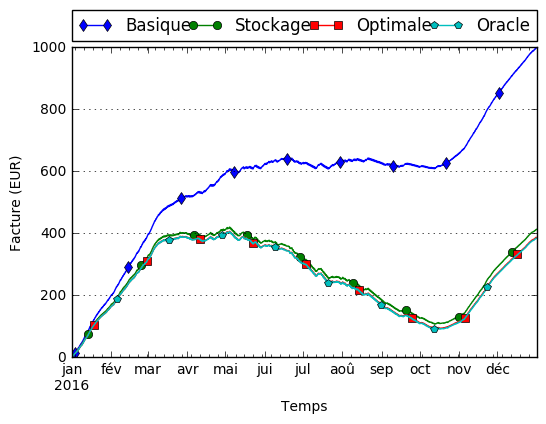

In [9]:
with open('results/pv.pkl', 'rb') as f:
        pv = pickle.load(f)
        
plt.figure()
marker = {'Basique':'d', 'Stockage':'o', 'Optimale':'s', 'Oracle':'p'}
for name in ['Basique', 'Stockage', 'Optimale', 'Oracle']:
    start = random.randint(0, 999)
    pv[name].plot(label=name, linestyle='-', marker=marker[name], markevery=(start,1000))
    print "%s : %f" % (name, pv[name][-1])

# plt.title("Comparaison des lois de consommation en photovoltaïque")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4,
           mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Temps")
plt.ylabel("Facture (EUR)")#€
ax.yaxis.grid()
plt.show()

## Facture avec l'éolien

In [10]:
# period = (bale.index.month == 1)# & (bale.index.day == 1)
period = (bale.index.year == 2016)
cap_batterie = 14
besoin = (bale['consommation'] - bale['prod-eol'])[period]
eol_dep = {}

# 1. en vendant systematiquement notre production de photovoltaique
eol_dep["Basique"] = LoiVente(bale['consommation'], bale['prod-eol'], period, prix_eolien)

# 2. On consomme notre production de photovoltaique et on vend ce qu'on ne consomme pas
# eol_dep["Consommation"] = LoiConso(bale['consommation'], bale['prod-eol'], period, prix_eolien)

# 3. On stocke et on n'utilise notre production qu'aux HP
[manqueNormal, stockageN] = LoiNormale('prod-eol',  cap_batterie, period)
eol_dep["Stockage"] = Depense(manqueNormal,prix_eolien)

# 4. On remplit la batterie en fin de HC
# [manqueAchat, stockageAchat] = LoiAchat('prod-eol', cap_batterie, period, 1.0)
# eol_dep["Achat"] = Depense(manqueAchat, prix_eolien)

# 5. On remplit la batterie en fin de HC en prévoyant notre besoin futur
[manqueOpt, stockageOpt] = LoiOptimal("prod-eol", cap_batterie, period)
eol_dep["Optimale"] = Depense(manqueOpt, prix_eolien)

# 6. Avec une prédiction de la consommation
[manquePred, stockagePred] = LoiOptimal("prod-eol", cap_batterie, period, conso=bale['prediction'])
eol_dep["Oracle"] = Depense(manquePred, prix_eolien)

Temps d'exécution: 
count    8784.000000
mean        0.006447
std         0.009850
min         0.002621
25%         0.002927
50%         0.003336
75%         0.004310
max         0.132032
dtype: float64
Temps d'exécution: 
count    8784.000000
mean        0.006001
std         0.008748
min         0.002615
25%         0.002879
50%         0.003188
75%         0.003986
max         0.075033
dtype: float64


In [11]:
with open('results/eolien.pkl', 'wb') as f:
        pickle.dump(eol_dep, f, pickle.HIGHEST_PROTOCOL)

Basique : 1718.793966
Stockage : 571.367088
Optimale : 531.670084
Oracle : 537.603138


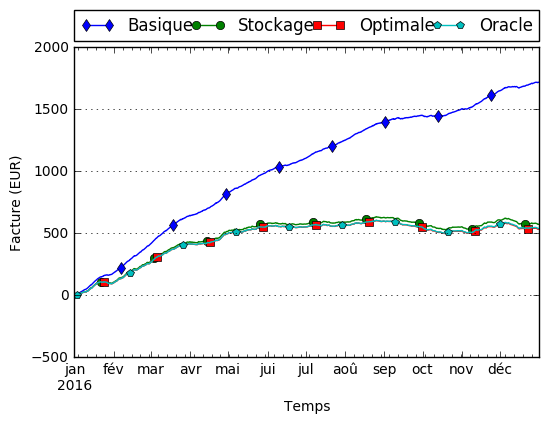

In [12]:
with open('results/eolien.pkl', 'rb') as f:
        eol_dep = pickle.load(f)
        
plt.figure()
marker = {'Basique':'d', 'Stockage':'o', 'Optimale':'s', 'Oracle':'p'}
for name in ['Basique', 'Stockage', 'Optimale', 'Oracle']:
    start = random.randint(0, 999)
    eol_dep[name].plot(label=name, linestyle='-', marker=marker[name], markevery=(start,1000))
    print "%s : %f" % (name, eol_dep[name][-1])
    

# plt.title("Comparaison des lois de consommation en éolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Temps")
plt.ylabel("Facture (EUR)")#€
ax.yaxis.grid()
plt.show()

## Quelle batterie faut-il ?

In [ ]:
batteries = range(2,20,2)#[7,10,14]
period = (bale.index.year == 2016)

# en photovoltaique
pv_batt = {}
for b in batteries:
    [manqueOpt, stockageOpt] = LoiOptimal("prod-pv", b, period)
    pv_batt[b] = Depense(manqueOpt, prix_pv)[-1]

# en eolien
eol_batt = {}
for b in batteries:
    [manqueOpt, stockageOpt] = LoiOptimal("prod-eol", b, period)
    eol_batt[b] = Depense(manqueOpt, prix_eolien)[-1]

# sans production
noprod_batt = {}
for b in batteries:
    [manqueOpt, stockageOpt] = LoiOptimal("no-prod", b, period)
    noprod_batt[b] = Depense(manqueOpt, 0)[-1]

In [19]:
with open('results/battery.pkl', 'w') as f:
        pickle.dump([pv_batt,eol_batt,noprod_batt], f)

In [ ]:
with open('results/battery.pkl', 'r') as f:
        [pv_batt,eol_batt,noprod_batt] = pickle.load(f)

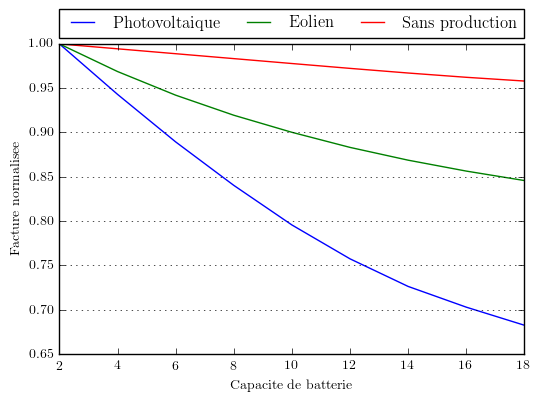

In [23]:
plt.figure()
plt.plot(batteries, pv_batt.values()/max(pv_batt.values()), label="Photovoltaique")
max_eol = np.max(np.abs(np.array(eol_batt.values())))
eol = (2*max_eol+ np.array(eol_batt.values()))
eol = eol/max(eol)
plt.plot(batteries,eol, label="Eolien")
plt.plot(batteries, noprod_batt.values()/max(noprod_batt.values()), label="Sans production")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Capacite de batterie")
plt.ylabel("Facture normalisee")
ax.yaxis.grid()
plt.show()

## Visualisation sur un jour

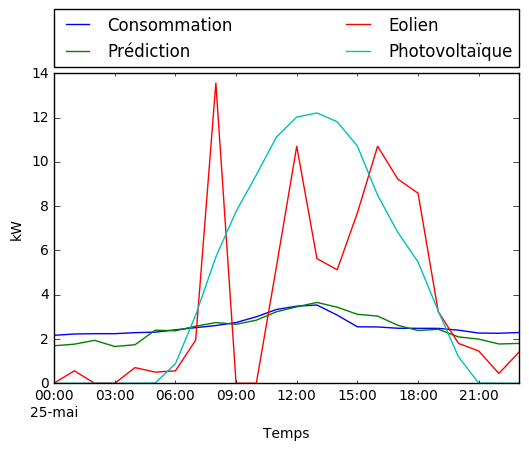

In [24]:
plt.figure()
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False
rc('font',**{'family':'serif','serif':['Calibri']})
period = (bale.index.year == 2016) & (bale.index.month == 5) & (bale.index.day == 25)
bale['consommation'][period].plot(label="Consommation")
bale['prediction'][period].plot(label="Prédiction")
bale['prod-eol'][period].plot(label="Eolien")
bale['prod-pv'][period].plot(label="Photovoltaïque")
plt.xlabel("Temps")
plt.ylabel("kW")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [25]:
mean_squared_error(
            bale[a2016]['consommation'], bale[a2016]['prediction'])/bale[a2016]['consommation'].mean()

0.089072475865077827

# A est difficile à trouver (poster session)

Courbe évolution de A = énergie achetée en prévision d'une période d'heures pleines = alpha*Cmax - E (énergie stockée en prévision d'une période d'heures creuses)

In [ ]:
# Cas du photovoltaique
factures = {}
cap_batterie = 7
period = (bale.index.year == 2016)
for alpha in np.arange(0.0, 1.1,0.1):
    [manqueAchat, stockageAchat] = LoiAchat('prod-pv', cap_batterie, period, alpha)
    factures[alpha] = Depense(manqueAchat, prix_pv).values[-1]
    print "%0.1f: %f," % (alpha, factures[alpha])


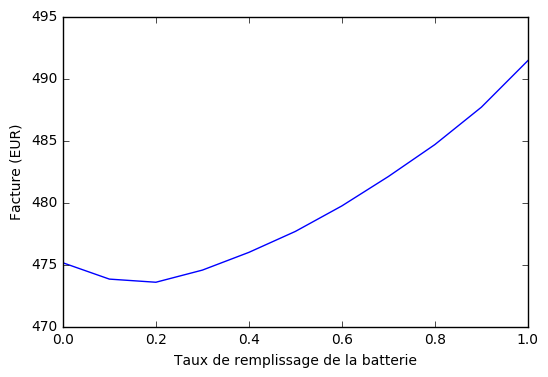

In [37]:
factures_pv = {0.0: 475.138230,0.1: 473.822078,0.2: 473.568979,0.3: 474.548010,0.4: 475.978243,0.5: 477.668359,
               0.6: 479.725811,0.7: 482.095081,0.8: 484.672211, 0.9: 487.686167, 1.0: 491.442713}
ofactures = collections.OrderedDict(sorted(factures_pv.items()))
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False
rc('font',**{'family':'serif','serif':['Calibri']})
plt.xlabel("Taux de remplissage de la batterie")
plt.ylabel("Facture (EUR)")
plt.plot(ofactures.keys(), ofactures.values(), '-')
plt.show()

In [ ]:
# Cas de l'éolien
factures = {}
cap_batterie = 7
period = (bale.index.year == 2016)
for alpha in np.arange(0.0, 1.1,0.1):
    [manqueAchat, stockageAchat] = LoiAchat('prod-eol', cap_batterie, period, alpha)
    factures[alpha] = Depense(manqueAchat, prix_eolien).values[-1]
    print factures[alpha]


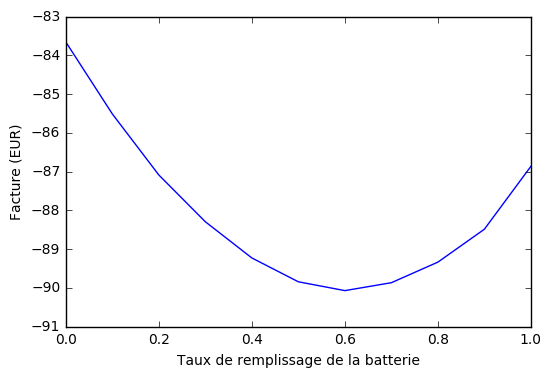

In [29]:
factures_eol = {0.0:-83.6600089858, 0.1:-85.5162253, 0.2:-87.0910324488, 0.3:-88.2976782744, 0.4:-89.2313780115, 0.5:-89.846330427, \
            0.6:-90.0739220686, 0.7:-89.8697712768, 0.8:-89.3389601694, 0.9:-88.4896040844, 1.0:-86.8672697882}
ofactures = collections.OrderedDict(sorted(factures_eol.items()))
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False
rc('font',**{'family':'serif','serif':['Calibri']})
plt.xlabel("Taux de remplissage de la batterie")
plt.ylabel("Facture (EUR)")
plt.plot(ofactures.keys(), ofactures.values(), '-')
plt.show()